<a href="https://colab.research.google.com/github/hakim-code/CSV-to-GluonTS-Converter/blob/main/Accent_LSTM_basemodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
import torch
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt



# Set a random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For CUDA-enabled GPUs
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # For consistent results on the cuDNN backend
    torch.backends.cudnn.benchmark = False  # Disable optimized kernels

# Example usage
set_seed(42)  # You can choose any number as your seed


# Import dataset

In [ ]:
file = '/content/PJMW_hourly_cleaned.csv'
df = pd.read_csv(file, parse_dates = True, sep=';', index_col = 'timestamp') #, index_col = 'timestamp'
short_df_len = int(len(df)*0.1)
df = df.iloc[:short_df_len] #cutdown the size
print(df.shape)
df.head(3)

(14320, 3)


,start,target,frequency checker
timestamp,,,
2002-12-31 01:00:00,31.12.02 01:00,5077,1
2002-12-31 02:00:00,31.12.02 02:00,4939,1
2002-12-31 03:00:00,31.12.02 03:00,4885,1


# Data preprocessing

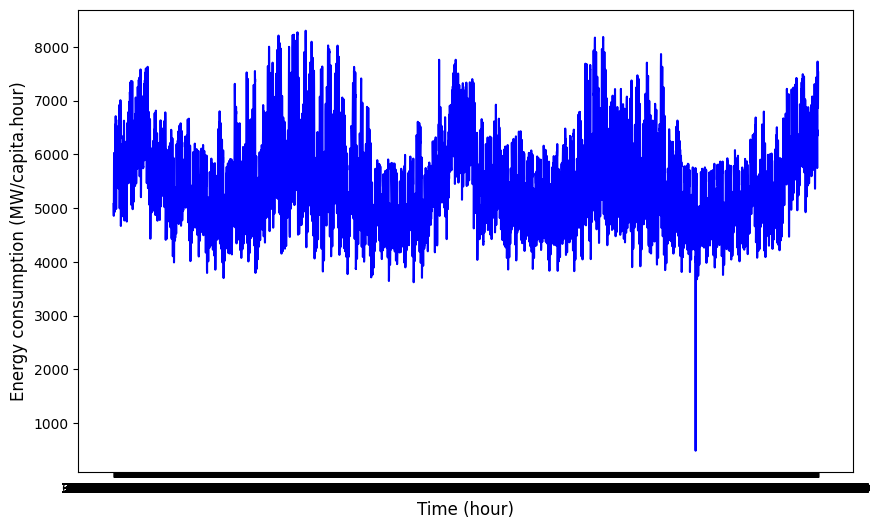

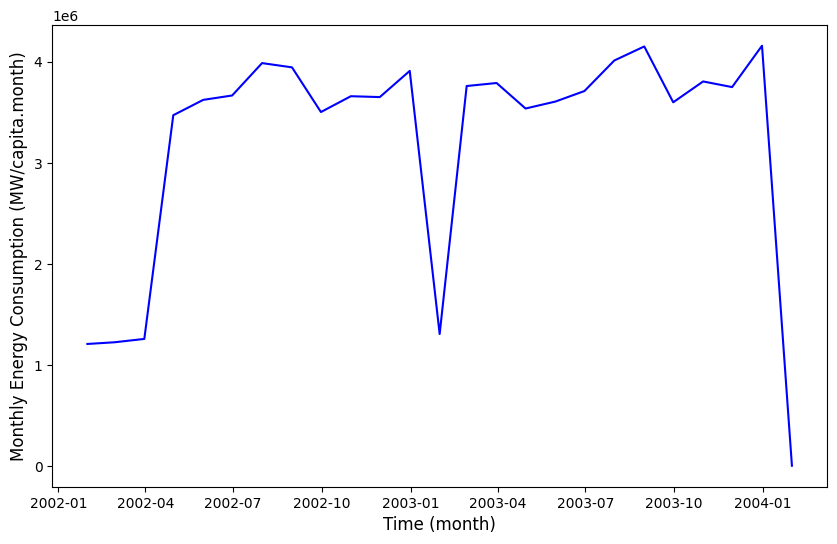

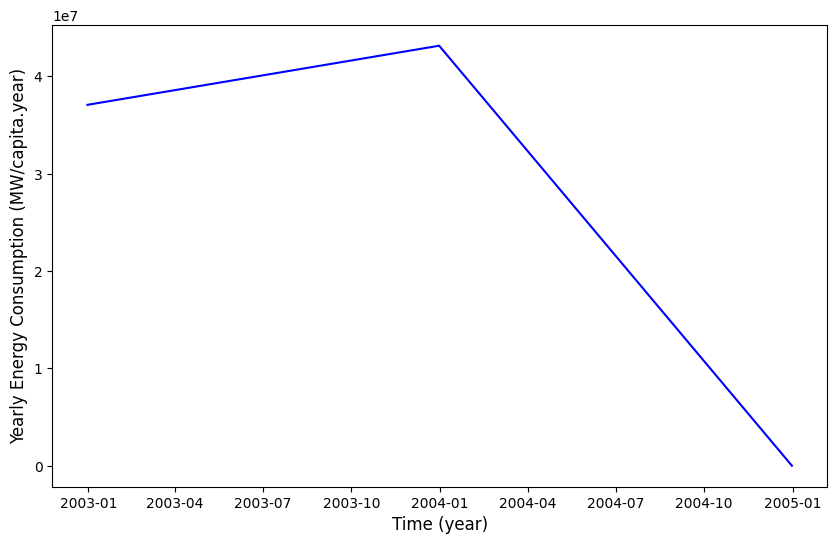

In [ ]:


# Define a function to draw time_series plot
def timeseries(x_axis, y_axis, x_label, y_label):
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis, y_axis, color='blue')
    plt.xlabel(x_label, {'fontsize': 12})
    plt.ylabel(y_label, {'fontsize': 12})
    plt.show()

# Plotting the hourly data
timeseries(df['start'] , df['target'], 'Time (hour)', 'Energy consumption (MW/capita.hour)')

# Extracting month and year from the timestamp for resampling
df['month'] = df.index.month
df['year'] = df.index.year

# Resampling to monthly data and plotting
dataset_by_month = df.resample('M')['target'].sum()  # Using only 'target' column to resample
timeseries(dataset_by_month.index, dataset_by_month, 'Time (month)', 'Monthly Energy Consumption (MW/capita.month)')

# Resampling to yearly data and plotting
dataset_by_year = df.resample('Y')['target'].sum()  # Using only 'target' column to resample
timeseries(dataset_by_year.index, dataset_by_year, 'Time (year)', 'Yearly Energy Consumption (MW/capita.year)')


In [ ]:
print(df.index)
df.head(3)

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2003-02-13 11:00:00', '2003-02-13 12:00:00',
               '2003-02-13 13:00:00', '2003-02-13 14:00:00',
               '2003-02-13 15:00:00', '2003-02-13 16:00:00',
               '2003-02-13 17:00:00', '2003-02-13 18:00:00',
               '2003-02-13 19:00:00', '2003-02-13 20:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=14320, freq=None)


,start,target,frequency checker,month,year
timestamp,,,,,
2002-12-31 01:00:00,31.12.02 01:00,5077,1,12,2002
2002-12-31 02:00:00,31.12.02 02:00,4939,1,12,2002
2002-12-31 03:00:00,31.12.02 03:00,4885,1,12,2002


In [ ]:
# Check for missing values
df = df.loc[:,['start','target']]

print('Total num of missing values:')
print(df.target.isna().sum())
print('')

# Locate the missing value
df_missing_date = df.loc[df.target.isna() == True]
print('The date of missing value:')
print(df_missing_date.loc[:,['start']])

# Replcase missing value with interpolation
df.target.interpolate(inplace = True)

df = df.drop('start', axis = 1)

Total num of missing values:
0

The date of missing value:
Empty DataFrame
Columns: [start]
Index: []


#1.3 Data Split

In [ ]:
# Split train data and test data
train_size = int(len(df)*0.9)

# train_data = df.target.loc[:train_size] -----> it gives a series
# Do not forget use iloc to select a number of rows
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]



#1.4 Data Transformation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Create an instance of MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Assuming 'train_data' and 'test_data' are your initial datasets before scaling
train_scaled = scaler.fit_transform(train_data)  # Fit scaler to training data and transform
test_scaled = scaler.transform(test_data)  # Only transform test data

print(train_scaled.shape)


(12888, 1)


#1.5 Data Input

In [ ]:


def create_dataset(X, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        v = X[i:(i + look_back)]
        Xs.append(v)
        ys.append(X[i + look_back])
    return np.array(Xs), np.array(ys)

# Use the first function to create datasets
look_back = 48
X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

# Now, split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# For the last 72 points in the test data:
context_plus_target_length = 48 + 24
new_data = test_data.iloc[-context_plus_target_length:]

# Scale the input for the last 72 points
scaled_new_data = scaler.transform(new_data)
X_24, y_24 = create_dataset(scaled_new_data, 48)

# Note: X_24 will be your input for the final predictions, and y_24 can be used to evaluate these predictions if you have the actual values.

print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_val.shape:', X_val.shape)
print('y_val.shape:', y_val.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)
print('X_24.shape:', X_24.shape)

print(X_train)

X_train.shape: (10272, 48, 1)
y_train.shape: (10272, 1)
X_val.shape: (2568, 48, 1)
y_val.shape: (2568, 1)
X_test.shape: (1384, 48, 1)
y_test.shape: (1384, 1)
X_24.shape: (24, 48, 1)
[[[0.5874824 ]
  [0.56981953]
  [0.56290797]
  ...
  [0.73979265]
  [0.69089978]
  [0.63765519]]

 [[0.56981953]
  [0.56290797]
  [0.5593242 ]
  ...
  [0.69089978]
  [0.63765519]
  [0.60911302]]

 [[0.56290797]
  [0.5593242 ]
  [0.56866761]
  ...
  [0.63765519]
  [0.60911302]
  [0.58697043]]

 ...

 [[0.61602457]
  [0.58722642]
  [0.56610777]
  ...
  [0.79879688]
  [0.7437604 ]
  [0.67643671]]

 [[0.58722642]
  [0.56610777]
  [0.55638039]
  ...
  [0.7437604 ]
  [0.67643671]
  [0.58069884]]

 [[0.56610777]
  [0.55638039]
  [0.55881224]
  ...
  [0.67643671]
  [0.58069884]
  [0.55138871]]]


In [ ]:
X_test[:33].shape
print(X_train.shape[1])
print(X_train.shape[2])

48
1


#Weight and Biase

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00


#2.0  Create models: get number of unit of hidden layer -> 64 nodes
1. Bidirectional LSTM
2. GRU

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import wandb

# Initialize wandb
wandb.init(project="gru_bilstm_timeseries")

# Define a GRU model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GRUModel, self).__init__()
        self.gru1 = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.gru2 = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x, _ = self.gru1(x)
        x, _ = self.gru2(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

# Define a BiLSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(BiLSTMModel, self).__init__()
        self.bilstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.bilstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        x, _ = self.bilstm1(x)
        x, _ = self.bilstm2(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

def fit_model(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    # Create DataLoaders
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    val_data = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        wandb.log({"epoch": epoch, "train_loss": avg_train_loss, "val_loss": avg_val_loss})

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

    return train_losses, val_losses

# Example usage
input_dim = X_train.shape[2]  # Number of features
hidden_dim = 64  # Number of hidden units


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Model performance

In [ ]:
def plot_loss(train_losses, val_losses, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Model Train vs Validation Loss for {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
    plt.savefig(f'{model_name}.jpg', format='jpg', dpi=1000)


Epoch 1/50, Train Loss: 0.007669830963030425, Validation Loss: 0.0010058884489927036
Epoch 2/50, Train Loss: 0.0008569854705634736, Validation Loss: 0.000784089565725407
Epoch 3/50, Train Loss: 0.000657078555592998, Validation Loss: 0.0007646002989119173
Epoch 4/50, Train Loss: 0.0006083812481493253, Validation Loss: 0.000873674810684166
Epoch 5/50, Train Loss: 0.0006148947255083086, Validation Loss: 0.0009515690956205442
Epoch 6/50, Train Loss: 0.0006194393249515827, Validation Loss: 0.0009287203318319755
Epoch 7/50, Train Loss: 0.0006121245575098178, Validation Loss: 0.0008613145629559378
Epoch 8/50, Train Loss: 0.0006001432221549682, Validation Loss: 0.0007820885084527516
Epoch 9/50, Train Loss: 0.0005864535189991507, Validation Loss: 0.0007052395169848073
Epoch 10/50, Train Loss: 0.0005724507212099211, Validation Loss: 0.0006239618935679398
Epoch 11/50, Train Loss: 0.0005496188412938427, Validation Loss: 0.0005633951603508734
Epoch 12/50, Train Loss: 0.0005162647501413424, Validati

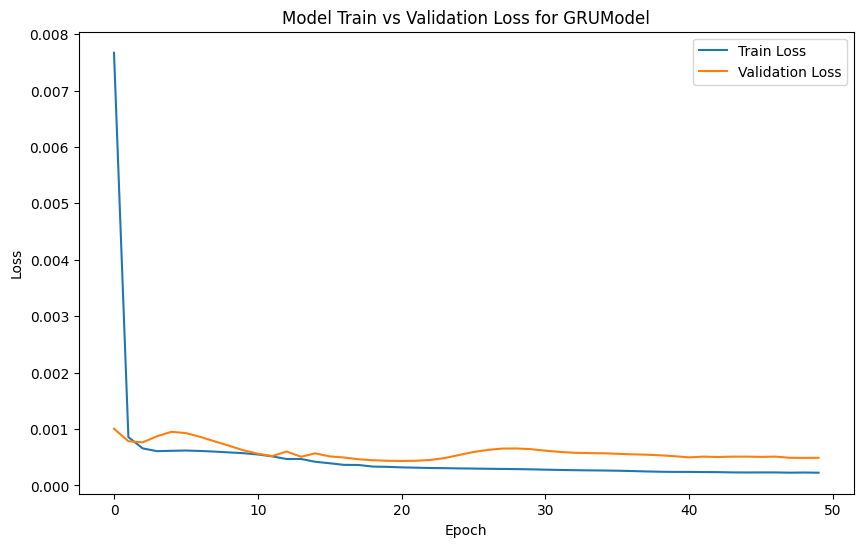

In [ ]:
# Create the model
model = GRUModel(input_dim, hidden_dim)

# Fit the model and get losses
train_losses, val_losses = fit_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=16)

# Plot losses
plot_loss(train_losses, val_losses, 'GRUModel')

Epoch 1/50, Train Loss: 0.010449793319031269, Validation Loss: 0.0014300717430273128
Epoch 2/50, Train Loss: 0.0010767362084345075, Validation Loss: 0.000801016880009144
Epoch 3/50, Train Loss: 0.0007399882096339364, Validation Loss: 0.0008314739772335912
Epoch 4/50, Train Loss: 0.0006891324570018713, Validation Loss: 0.00091659872012552
Epoch 5/50, Train Loss: 0.0006617044137922355, Validation Loss: 0.0009280115630628066
Epoch 6/50, Train Loss: 0.0006143912112158455, Validation Loss: 0.0008915899843543331
Epoch 7/50, Train Loss: 0.000580786479255277, Validation Loss: 0.0008483250595695015
Epoch 8/50, Train Loss: 0.0005675706759524405, Validation Loss: 0.0007935152113662168
Epoch 9/50, Train Loss: 0.0005567432210703705, Validation Loss: 0.0007285444886710709
Epoch 10/50, Train Loss: 0.0005427547001436381, Validation Loss: 0.0006774477642805024
Epoch 11/50, Train Loss: 0.0004961156358310809, Validation Loss: 0.0007464740335325254
Epoch 12/50, Train Loss: 0.0005200154539742587, Validatio

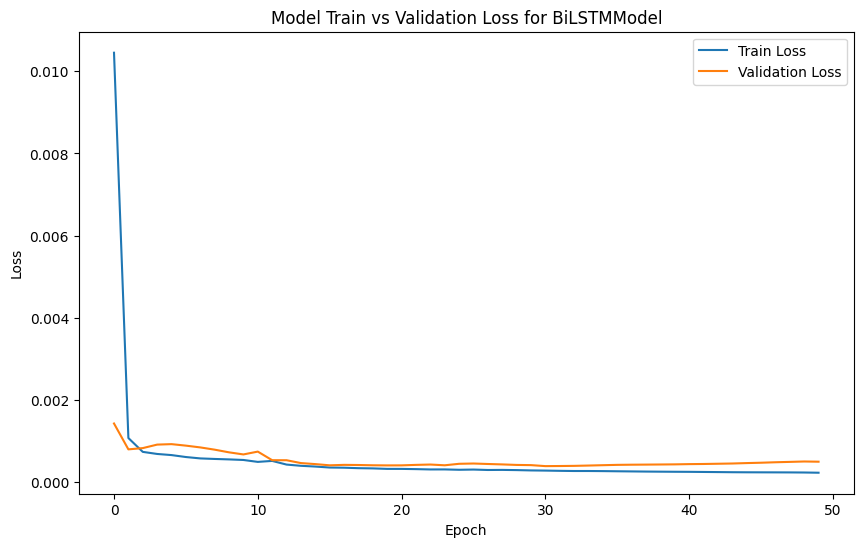

In [ ]:
# Create the model
model = BiLSTMModel(input_dim, hidden_dim)

# Fit the model and get losses
train_losses, val_losses = fit_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=16)

# Plot losses
plot_loss(train_losses, val_losses, 'BiLSTMModel')

#2.2 Inverse Transform data back to original data space

In [ ]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))


#Make Prediction

In [ ]:
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(model, X_val, y_val, scaler=None):
    # Ensure the model is in evaluation mode
    model.eval()

    # Convert data to PyTorch tensors
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    # DataLoader for validation set
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    predictions = []
    # Disable gradient calculation
    with torch.no_grad():
        for inputs, _ in val_loader:
            # Make predictions
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())

    # Concatenate all predictions
    predictions = np.concatenate(predictions, axis=0)

    # Inverse transform the predictions and actual values if a scaler is provided
    if scaler:
        predictions = scaler.inverse_transform(predictions)
        y_val = scaler.inverse_transform(y_val.reshape(-1, 1))

    # Calculate evaluation metrics
    mse = mean_squared_error(y_val, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, predictions)

    # You can return either RMSE or MAE, depending on which metric you want to use for evaluation
    return rmse  # or return mae



In [ ]:
import itertools
def grid_search(model_class, param_grid, X_train, y_train, X_val, y_val):
    best_model = None
    best_score = float('inf')
    best_params = {}

    for params in itertools.product(*param_grid.values()):
        params_dict = dict(zip(param_grid.keys(), params))
        print(f"Training with parameters: {params_dict}")

        # Create a new instance of the model with the given parameters
        model = model_class(input_dim=X_train.shape[2], hidden_dim=params_dict['hidden_dim'])

        # Fit the model
        fit_model(model, X_train, y_train, X_val, y_val, epochs=params_dict['epochs'], batch_size=params_dict['batch_size'])

        # Evaluate the model
        score = evaluate_model(model, X_val, y_val)

        if score < best_score:
            best_score = score
            best_model = model
            best_params = params_dict

    return best_model, best_score, best_params

# Define the hyperparameter grid
param_grid = {
    'hidden_dim': [32, 64, 128],
    'batch_size': [16, 32, 64],
    'epochs': [20, 40]
}

# Example usage of grid_search
best_gru, best_score_gru, best_params_gru = grid_search(BiLSTMModel, param_grid, X_train, y_train, X_val, y_val)
print(f"Best GRU Model: {best_params_gru}, Score: {best_score_gru}")

Training with parameters: {'hidden_dim': 32, 'batch_size': 16, 'epochs': 20}
Epoch 1/20, Train Loss: 32303530.535825547, Validation Loss: 1871.656446373981
Epoch 2/20, Train Loss: 31869749.825545173, Validation Loss: 6471.993524966033
Epoch 3/20, Train Loss: 31459769.342679128, Validation Loss: 13716.202973359861
Epoch 4/20, Train Loss: 31056116.62305296, Validation Loss: 23586.48322253494
Epoch 5/20, Train Loss: 30656758.380062304, Validation Loss: 36075.84799592391
Epoch 6/20, Train Loss: 30260923.302180685, Validation Loss: 51181.771108307454
Epoch 7/20, Train Loss: 29868237.1635514, Validation Loss: 68903.54682647515
Epoch 8/20, Train Loss: 29478497.003115267, Validation Loss: 89241.19016886647
Epoch 9/20, Train Loss: 29091591.27258567, Validation Loss: 112194.36422748448
Epoch 10/20, Train Loss: 28707454.44080997, Validation Loss: 137762.94089673914
Epoch 11/20, Train Loss: 28326050.255451713, Validation Loss: 165946.06385869565
Epoch 12/20, Train Loss: 27947357.200934578, Validat

#Plot Data: Test vs Prediction

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Assuming scaler is previously defined and fitted
# Assuming model_gru and model_bilstm are your trained models

def prediction(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            outputs = model(batch[0])  # Assuming the dataloader returns a tuple (input, target)
            predictions.append(outputs.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)
    return scaler.inverse_transform(predictions)

def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='Test Data')
    plt.plot(np.arange(range_future), np.array(prediction), label='Prediction')
    plt.title(f'Test Data vs Prediction for {model_name}')
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily Water Consumption ($m^3$/capita.day)')
    plt.show()

# Use the prediction function
prediction_gru = prediction(model_gru, X_24_loader)
prediction_bilstm = prediction(model_bilstm, X_24_loader)

# Plot the results
plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)


#Evaluation: MAE and RMSE

In [ ]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(f'{model_name}:')
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'Root Mean Square Error: {rmse:.4f}')
    print('')


# Multi-step forecasting

In [ ]:
X_24_tensor = torch.tensor(X_24, dtype=torch.float32)
X_24_loader = DataLoader(X_24_tensor, batch_size=16)


#Prediction Function

In [ ]:
def prediction(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs in dataloader:
            inputs = inputs if isinstance(inputs, torch.Tensor) else inputs[0]  # Extracting tensor from dataloader
            outputs = model(inputs.float())
            predictions.append(outputs.cpu().numpy())  # Move outputs to CPU before converting to NumPy

    predictions = np.concatenate(predictions, axis=0)
    prediction = scaler.inverse_transform(predictions)  # Assuming 'scaler' is already defined
    return prediction


#Prediction Implement

In [ ]:
import matplotlib.dates as mdates

def plot_multi_step(history, prediction1, prediction2, timestamps):
    plt.figure(figsize=(15, 6))

    # Convert history and predictions to numpy if they aren't already
    history_values = np.array(history) if isinstance(history, np.ndarray) else history.to_numpy()
    prediction1 = np.array(prediction1)
    prediction2 = np.array(prediction2)

    # Create a range for the timestamps
    history_timestamps = timestamps[:len(history_values)]
    future_timestamps = timestamps[-len(prediction1):]

    plt.plot(history_timestamps, history_values, label='History')
    plt.plot(future_timestamps, prediction1, label='Forecasted with GRU')
    plt.plot(future_timestamps, prediction2, label='Forecasted with BiLSTM')

    plt.legend(loc='upper right')
    plt.xlabel('Time')
    plt.ylabel('Value')

    # Format x-axis with date format
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.gcf().autofmt_xdate()  # Rotation

    # Set the y-axis limits if necessary to ensure all data is visible
    plt.ylim(min(history_values.min(), prediction1.min(), prediction2.min()),
             max(history_values.max(), prediction1.max(), prediction2.max()))

    plt.show()

# Assuming `new_data` has a datetime index or a column that can be converted to datetime
timestamps = new_data.index.to_pydatetime()

plot_multi_step(new_data.iloc[:-24], prediction_gru, prediction_bilstm, timestamps)


In [ ]:
import itertools


In [ ]:
# Hyperparameter grid
param_grid = {
    'hidden_dim': [32, 64, 128],
    'batch_size': [16, 32, 64],
    'epochs': [20, 40]
}

# Grid search for GRU
best_gru, best_score_gru, best_params_gru = grid_search(GRUModel, param_grid, X_train, y_train)

print(f"Best GRU Model: {best_params_gru}, Score: {best_score_gru}")

# Grid search for BiLSTM (optional)
# best_bilstm, best_score_bilstm, best_params_bilstm = grid_search(BiLSTMModel, param_grid, X_train, y_train)
# print(f"Best BiLSTM Model: {best_params_bilstm}, Score: {best_score_bilstm}")
